# Supervised Learning II – Klassifikation mit Logistischer Regression

## Lernziele

Am Ende dieses Notebooks kannst du:

* den Unterschied zwischen Regressions- und Klassifikationsproblemen erklären,
* Klassifikationsmodelle mit Scikit-learn trainieren und bewerten,
* die logistische Regression auf geeignete Probleme anwenden und
* gängige Metriken zur Evaluation von Klassifikationsmodellen interpretieren.

# Klassifikation mit Logistischer Regression

## Einführung in die Klassifikation

Bisher haben wir uns mit **Regression** beschäftigt, also dem Vorhersagen von kontinuierlichen Größen, zum Beispiel der Fertigungsdauer in Minuten auf Basis der Maschinenanzahl. Doch in vielen praktischen Anwendungen interessiert uns nicht ein kontinuierlicher Zahlenwert, sondern eine **Zugehörigkeit zu einer Kategorie**:

* Ist ein Produkt defekt oder nicht?
* Handelt es sich bei einem Bildinhalt um eine Katze oder einen Hund?
* Wird ein Kunde den Vertrag kündigen: ja oder nein?

Solche Aufgaben zählen zum **Klassifikationsproblem**, einer eigenen Klasse des Supervised Learning. Die Zielvariable $y$ ist dabei **nicht kontinuierlich**, sondern **diskret** – oft binär (z.B. 0/1, ja/nein), oft auch mehrstufig (z.B. Klassen A, B, C).

### Beispiel: Defekte Steckverbindungen

Stellen wir uns vor, wir arbeiten in der Qualitätssicherung eines Unternehmens, das Steckverbindungen für Fahrzeuge herstellt. Bei jeder Verbindung messen wir zwei Größen:

* die **Kontaktnormalkraft** (x-Achse): wie stark wird der Stecker in die Buchse gedrückt?
* den **elektrischen Kontaktwiderstand** (y-Achse): je geringer dieser ist, desto besser leitet die Verbindung Strom.

Die Unternehmensdevise ist: Ein Kontakt mit einem Widerstand von über **300 mΩ** gilt als **defekt** und wird gewartet.

Die folgende Grafik zeigt eine Stichprobe unserer Steckverbindungen. Jede Verbindung ist entweder **defekt** (oranges Dreieck) oder **nicht defekt** (grünes Quadrat):

In [ ]:
### Einmalig zu Beginn ausführen
!git clone https://github.com/wolfromanlist/MLForEngineers.git
%cd MLForEngineers/Notebooks/

from google.colab import output
output.enable_custom_widget_manager()

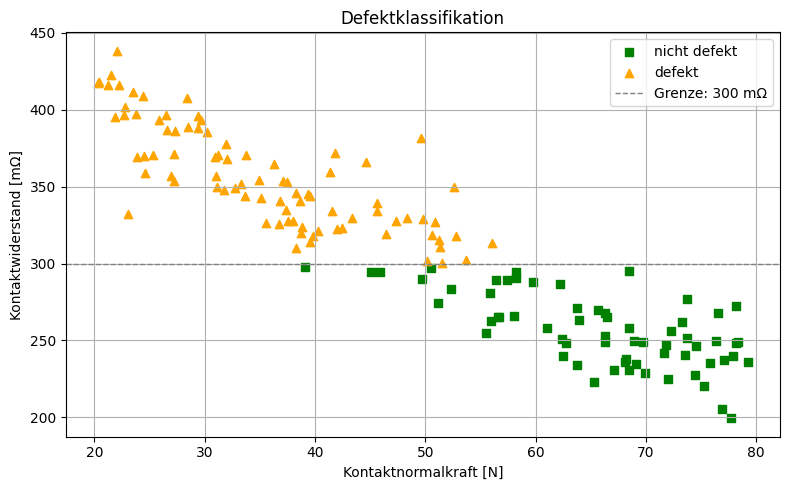

In [1]:
from LogRegWidgets_Plotly import *
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv('../Data/classification_data_resistance_force.csv')

force = data['Normalkraft']
resistance = data['Widerstand']
is_defective = resistance > 300

fig, ax = plt.subplots(figsize= (8,5))
ax.scatter(force[~is_defective], resistance[~is_defective],
            c='green', marker='s', label='nicht defekt')
ax.scatter(force[is_defective], resistance[is_defective],
            c='orange', marker='^', label='defekt')
ax.axhline(300, color='gray', linestyle='--', linewidth=1, label='Grenze: 300 mΩ')

plt.xlabel("Kontaktnormalkraft [N]")
plt.ylabel("Kontaktwiderstand [mΩ]")
plt.title("Defektklassifikation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In der Grafik ist klar zu erkennen: Defekte Verbindungen haben meist **niedrigere Kontaktnormalkräfte** und **höhere Widerstände**. Unser Ziel ist es nun, ein Modell zu bauen, das diese Regel **automatisch erlernt**, um bei zukünftigen Steckverbindungen allein anhand der Kontaktkraft schnell und zuverlässig eine Entscheidung treffen zu können: defekt oder nicht?

Wir brauchen also eine binäre Ausgabe (0 = defekt, 1 = nicht defekt) oder, noch nützlicher, eine Ausgabe, die uns sagt mit welcher Wahrscheinlichkeit ein Datenpunkt einen defekten Stecker beschreibt. Und genau hier kommt die **logistische Funktion** (oder Sigmoid-Funktion) ins Spiel.

## Zutat 1: Das logistische Modell

Der Schlüssel, um von der Regression zur (binären) Klassifikation zu gelangen, liegt in der Transformation der Eingangsdaten zu einem Wert zwischen 0 und 1, den wir als **Wahrscheinlichkeit für die Zugehörigkeit zur Klasse 1** interpretieren können. In unserem Fall definieren wir willkürlich Klasse 1 = *defekt*.

### Die Sigmoidfunktion

Um aus einem beliebigen Eingangswert $x$ eine Vorhersage zwischen 0 und 1 zu erzeugen, verwenden wir die sogenannte **Sigmoidfunktion**:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
\tag{1}
$$

wobei  $z = w \cdot x + b$ einfach eine lineare Vorhersage ist. Konkret heißt das, dass wir bei der logistischen Regression einfach eine lineare Funktion als Vorhersage nehmen und dann eine nichtlineare Funktion, die Sigmoid-Funktion, darauf anwenden, um die Vorhersage auf einen Bereich zwischen 0 und 1 zu beschränken. Die Sigmoid-Funktion sieht dann so aus:

![](../Images/sigmoid.png)

Die Sigmoidfunktion (1) hat folgende Eigenschaften:

* Sie nimmt beliebige reelle Zahlen als Eingabe und gibt einen Wert im Bereich $(0, 1)$ zurück.
* Negative Werte führen zu Ausgaben nahe 0, große positive Werte zu Ausgaben nahe 1 (für $w>0$).
* Sie ist **glatt** und **differenzierbar**, was für das Training mit Gradientenverfahren (später mehr dazu) wichtig ist.

Im Widget könnt ihr selbst ausprobieren, wie sich die Funktion für verschiedene Parameterkombinationen verhält. Versucht herauszufinden, was die Parameter $w$ und $b$ bewirken. Was passiert, wenn $w$ negativ wird?

In [2]:
sigmoid_widget()

interactive(children=(FloatSlider(value=0.0, description='Parameter w', max=3.0, min=-3.0), FloatSlider(value=…

Damit ergibt sich das vollständige Modell der logistischen Regression:

$$
\hat{y} = \sigma(w \cdot x + b)
$$

Hierbei ist $\hat{y}$ die vom Modell vorhergesagte Wahrscheinlichkeit, dass die Instanz zur **positiven Klasse** gehört (z. B. *defekt*). Um daraus eine konkrete Klassenzuordnung zu treffen, kann man einen **Schwellwert** setzen (z. B. 0.5):
Wenn $\hat{y} \geq 0.5$, klassifizieren wir die Verbindung als *defekt*, andernfalls als *nicht defekt*.

Damit die Daten allerdings von der Sigmoid-Funktion vorhergesagt werden können, müssen wir diesen ihre zugehörigen Labels zuweisen. Alle Daten über dem Widerstandswert von $300$ $\mathrm{m}\Omega$", die also zur Klasse 1 gehören, bekommen das Label 1, alle anderen, die zur Klasse 0 gehören, bekommen das Label 0. Dies ist hier grafisch dargestellt:

![](../Images/animation.gif)

### Warum heißt es eigentlich logistische „Regression“?

Obwohl die **logistische Regression** ein Modell zur **Klassifikation** ist, trägt sie den Begriff *Regression* im Namen. Mit dem Wissen über die Sigmoid-Funktion lässt sich das nun einfach rechtfertigen: Letztendlich bestimmen wir immer noch die Parameter $w$ und $b$ um einen möglichst guten "Fit" der Sigmoid-Funktion an die auf 0 und 1 gemappten Daten zu erlangen. Allein die **Nutzung der logistischen Funktion** ermöglicht es uns, diese lineare Vorhersage so zu transformieren, dass sie sich **für ein Klassifikationsproblem eignet**. Dahinter steckt aber, genau wie bei der linearen Regression, eine geeignete Wahl der Modellparameter, so dass der Vorhersagefehler minimiert wird. 

Aber welcher Fehler ist das eigentlich? Können wir ebenfalls weiterhin mit der MSE-Verlustfunktion arbeiten? Genau das schauen wir uns im nächsten Abschnitt an.

## Zutat 2: Die Verlustfunktion - Von MSE zu BCE

Im obigen Beispiel haben wir zwei Klassen, *defekt* (Klasse 1) und *nicht defekt* (Klasse 0), und wollen auf Basis der Normalkraft bestimmen, ob eine Steckverbindung zur Klasse 1 oder 0 gehört. Es handelt sich hierbei um eine **binäre Klassifikation**, da wir nur zwei mögliche Klassen haben. 

Wir wissen, dass unser Modell eine Zahl zwischen 0 und 1 ausgibt, welche die Wahrscheinlichkeit darstellt, dass ein Datenpunkt zur Klasse 1 gehört. Alle $\hat{y}$ über $0.5$ werden dabei als Klasse 1 gewertet, da die Wahrscheinlichkeit größer als 50% beträgt. Je höher der Wert, desto größer die "Sicherheit" des Modells. Obwohl wir also nur einen Wert als Ausgabe bekommen, können wir zwei Sachen daraus ableiten:

1. "Ist die Vorhersage richtig oder falsch?" und
2. "Wie sicher ist sich das Modell?"

Was wir von einer geeigneten Fehlerfunktion erwarten ist klar: 
- Eine falsche Vorhersage soll einen höheren Fehler haben als eine richtige. 

Es sind aber zwei weitere Sachen wichtig:
- Eine falsche Vorhersage, die mit hoher Sicherheit getroffen wurde, soll stärker bestraft werden.
- Eine Vorhersage nahe $0.5$ soll nicht belohnt werden, da sie kaum Informationen liefert.

### Warum nicht einfach MSE?

Ein naheliegender Vorschlag ist die Verwendung des mittleren quadratischen Fehlers (MSE), den wir bereits aus der linearen Regression kennen:

$$
\mathrm{MSE} = (\hat{y} - y)^2
$$

Aber dieser Fehler misst nur den Abstand zwischen Vorhersage $\hat{y}$ und Zielwert $y$, ohne die Unsicherheit der Vorhersage sinnvoll zu berücksichtigen: Angenommen, das richtige Label sei $y = 1$. Die Vorhersage $\hat{y} = 0$, also die schlechteste Vorhersage, die überhaupt möglich ist, liefert einen MSE von $1$ - ein ziemlich niedriger Wert für eine komplett falsche Aussage. Der beste erreichbare Wert ist in diesem Problem 0, wenn $\hat{y} = y$. Je schlechter sich eine gute Vorhersage von einer schlechten unterscheiden lässt, desto schwieriger wird die numerische Minimierung der Fehlerfunktion. Am besten wäre es also, wenn der Fehler unbegrenzt ansteigen würde, je weiter man sich der falschen Klasse nähert. Der MSE ist demnach nicht gut geeignet für Klassifikation, weil er nicht die Wahrscheinlichkeit für das richtige Label berücksichtigt, sondern nur die Differenz der Zahlen.

Wir werden nun sehen, dass wir eine geeignetere Fehlerfunktion erhalten können, wenn wir sie mit dem sogenannten **Maximum-Likelihood-Ansatz** herleiten.

### Eine bessere Fehlerfunktion

#### Das Setting

Stellen wir uns vor, wir ziehen Zettel aus einer Box. Es gibt zwei Arten von Zetteln: solche mit der Zahl "0" und solche mit der Zahl "1". Das Ereignis $y = 1$ beschreibt das Ziehen einer "1", entsprechend beschreibt $y = 0$ das Ziehen einer "0". Die Wahrscheinlichkeit $p$ einen Zettel mit "1" zu ziehen ist 
$$
P(y = 1) = p = \frac{\mathrm{N_1}}{N},
$$
wobei $N_1$ die Zahl der Zettel mit "1" und $N$ die Gesamtanzahl der Zettel ist. Da wir die genauen Anzahlen nicht kennen, ist $p$ zunächst unbekannt. Andersherum ist die Wahrscheinlichkeit $q$ einen Zettel mit "0" zu ziehen
$$
P(y = 0) = q = \frac{\mathrm{N_0}}{N} = 1 - p,
$$
wobei wir genutzt haben, dass $N_0 = N - N_1$ ist.

#### Das Experiment

Jetzt ziehen wir 20 Zettel aus der Box und bekommen beispielsweise 13 mal eine "1" und 7 mal eine "0". Die Wahrscheinlichkeit für genau dieses Ergebnis berechnen wir mit:
$$
L_{13;7}(p) = p^{13} \cdot q^7 = p^{13} \cdot (1-p)^7.
$$
Wichtig: $L$ ist hier eine Funktion von $p$. Sie beschreibt die Wahrscheinlichkeit (Likelihood), mit der das beobachtete Ergebnis unter einem bestimmten $p$ auftritt. 

#### Maximum Likelihood Estimation

Der zentrale Gedanke ist jetzt:
> Wir können nun das $p$ bestimmen, das das Auftreten des beobachteten Ergebnisses (13 mal "1", 7 mal "0") am wahrscheinlichsten macht, also $L_{13;7}(p)$ maximiert.

Wir treffen also die Annahme, dass die Wahl von $p$, welches $L$ maximiert, die "wahre" Wahrscheinlichkeit am ehesten widerspiegelt. Der Grund ist: Mit jedem anderen $p$ wäre das beobachtete Ergebnis unwahrscheinlicher. Deshalb heißt das Verfahren Maximum Likelihood Estimation. Diese Schätzung ist natürlich nicht exakt richtig, aber sie verbessert sich mit wachsender Stichprobengröße.

Im folgenden Widget könnt ihr ausprobieren, welches $p$ für den obigen Fall die höchste Wahrscheinlichkeit für das beobachtete Ergebnis ergibt.

In [7]:
likelihood_widget()

interactive(children=(FloatSlider(value=0.5, description='p', max=1.0, step=0.01), Output()), _dom_classes=('w…

#### Von Maximum Likelihood zur Verlustfunktion

Das ist alles schön und gut, aber was hat es mit der logistischen Regression zu tun? Einiges! Wir werden sehen, dass man aus einer beliebigen Likelihood-Funktion sehr einfach eine Fehlerfunktion machen kann. Dafür müssen wir zunächst für den Fall der Klassifikation eine Likelihood-Funktion aufstellen. Zum Glück unterscheidet sich die binäre Klassifikation nicht sonderlich vom Ziehen zweier Zettel aus einer Box.

##### Einmal Ziehen - Mathematisch formuliert:
Vereinfachen wir das Experiment von oben, indem wir nur _einen_ Zettel ziehen. 
Die Likelihood für ein beobachtetes Ergebnis $y$ ist:
$$
L(p) = p^y \cdot (1-p)^{1-y}
$$


Zur Erinnerung: $y$ kann die Werte $0$ und $1$ annehmen. \
Beachtet, dass $L$:
1. die **richtige Wahrscheinlichkeit** des beobachteten Ereignisses ausgibt: Wenn $y=1$, dann ist $L_{1;0} = p \cdot 1 = p$, also genau die Wahrscheinlichkeit eine "1" zu ziehen. Ziehen wir eine "0", dann gilt $L_{0;1} = 1 \cdot (1-p) = (1-p) = q$, also genau die Gegenwahrscheinlichkeit. 
2. eine Schätzung der **maximal wahrscheinlichen Verteilung** in Anbetracht des beobachteten Ergebnisses abgibt: Wenn wir eine "1" ziehen, ist es wahrscheinlicher, dieses Ergebnis zu erhalten, wenn $p > q$. In diesem Fall wird $L$ zu $p$. Wenn wir eine "0" ziehen, ist es wahrscheinlicher, dieses Ergebnis zu erhalten, wenn $q > p$, und in diesem Fall wird $L$ zu $q$.

##### Mehrmals ziehen - Mathematisch formuliert:
Wir haben also mit $L$ jetzt eine Schätzung der "wahrscheinlichsten" Verteilung, wenn wir _einen_ Durchlauf machen. Was ist, wenn wir $n$ Mal aus der Box ziehen mit $n$ verschiedenen Ergebnissen $y_1, y_2, ..., y_n$?
Dann multiplizieren wir die Wahrscheinlichkeiten der einzelnen (unabhängigen) Ereignisse einfach zusammen:
$$
L(p) = \prod_{i=1}^n p^{y_i} \cdot (1-p)^{1-y_i}
$$

Beispielsweise bekommen wir für den Fall unseres originalen Beispiels genau $L_{13;7} = p^{13} \cdot (1-p)^7$ raus. Macht euch das klar, falls es das nicht ist.

##### Der Bogen zur logistischen Regression:
Jetzt wird's spannend: Auch in der logistischen Regression haben wir eine Wahrscheinlichkeitsvorhersage $\hat{y}_i$ für jedes echte Label $y_i$. Wir wollen die Frage beantworten: "In Anbetracht der bekannten Labels $y_i$, was sind die Wahrscheinlichkeiten $\hat{y}_i$, welche die beobachteten Daten am wahrscheinlichsten machen?". Ersetzt also einfach $p$ durch $\hat{y}_i$ und wir erhalten als Likelihood-Funktion im Fall der logistischen Regression:
$$
L(\hat{y}_i) = \prod_{i=1}^n {\hat{y}_i}^{y_i} \cdot (1-\hat{y}_i)^{1-y_i}
$$

Wenn wir dieses $L(\hat{y}_i)$ maximieren, sollte unser Modell für alle Datenpunkte eine Vorhersage $\hat{y}_i$ machen, die die beobachteten Daten am wahrscheinlichsten macht.

**Verschnaufpause:** \
Geschafft! Wenn ihr alles bis zu diesem Schritt nachvollziehen konntet, ist der Rest einfach. Jetzt machen wir aus der Likelihood eine Verlustfunktion. Denn bis jetzt ist die Likelihood etwas, das wir maximieren wollen. Sie misst also in gewisser Weise, wie **gut** unser Modell die Daten vorhersagt. Um das Modell zu trainieren, wollen wir wie bei der linearen Regression aber eine Verlustfunktion formulieren, die misst, wie **schlecht** das Modell die Daten vorhersagt. Ob man nun die Likelihood maximiert oder die Verlustfunktion minimiert ist letztendlich egal. Allerdings funktionieren die meisten Lösungsverfahren mit dem Prinzip der Minimierung einer Verlustfunktion, weshalb wir das hier auch so machen. 
Wie machen wir aus der Likelihood eine Verlustfunktion? Das geht in zwei Schritten:

##### Erster Schritt - Logarithmieren:
Die Likelihood $L$ ist ein Produkt aus vielen Faktoren (so viele wie Datenpunkte). Solche Produkte sind rechnerisch unpraktisch und numerisch instabil, insbesondere wenn die $\hat{y}_i$ nahe bei 0 oder 1 liegen – dann werden viele sehr kleine Zahlen miteinander multipliziert, was schnell zu Rundungsfehlern führt. Ein üblicher Trick ist daher, den Logarithmus der Likelihood zu nehmen. Der Logarithmus ist eine streng monoton steigende Funktion, d.h. das Maximum bleibt an derselben Stelle(!). Das Gute ist, dass das Produkt zu einer Summe wird:

$$
\log L = \log\left(\prod_{i=1}^n \hat{y}_i^{y_i} \cdot (1 - \hat{y}_i)^{1 - y_i}\right) = \sum_{i=1}^n \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]
$$

Diese Funktion nennt man auch die **log-Likelihood**. Je größer sie ist, desto wahrscheinlicher macht das Modell mit seinen Vorhersagen $\hat{y}_i$ die tatsächlich beobachteten Labels $y_i$.

##### Zweiter Schritt - Minimieren statt maximieren:
Da wir das Modell durch *Minimierung* einer Verlustfunktion trainieren wollen (z. B. mit Gradientenverfahren), kehren wir das Vorzeichen um. Denn $L$ maximieren ist genau gleichwertig zu $(-L)$ minimieren. Typischerweise nehmen wir auch den Mittelwert von $L$ über alle Daten, einfach damit $L$ nicht zu groß wird und keine numerischen Probleme auftreten. Final haben wir also:

$$
\mathrm{BCE} = - \frac{1}{n} \sum_{i=1}^n \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]
\tag{1}
$$

Voilà! Das ist unsere neue Fehlerfunktion – sie heißt **Binary Cross-Entropy** (BCE) und ist die Standardverlustfunktion bei binären Klassifikationsproblemen.

**Intuition:**

* Wenn $y_i = 1$, bleibt nur der erste Term übrig: $- \log(\hat{y}_i)$. Je näher $\hat{y}_i$ an 1, desto kleiner der Verlust. Liegt $\hat{y}_i$ nahe bei 0, wird der Verlust größer.
* Wenn $y_i = 0$, bleibt nur der zweite Term übrig: $- \log(1 - \hat{y}_i)$. Auch hier gilt: je näher $\hat{y}_i$ an 0, desto besser.

**Wichtig**: Ist die Vorhersage einer Klasse besonders schlecht, beispielsweise $y=1$ und $\hat{y} = 0.1$, dann wird der BCE uneingeschränkt größer, je schlechter die Vorhersage wird! Wird $\hat{y}$ noch kleiner, dann wächst der jeweilige Summand ($- y \cdot \log(\hat{y})$) unbeschränkt, da $-\log(0) \rightarrow \infty$. Der BCE bestraft also nicht nur falsche Vorhersagen, sondern auch falsche Vorhersagen mit hoher Sicherheit besonders stark – genau das, was wir wollen!

##### Widget

Im folgenden Widget haben wir zwei Datenpunkte $y_1$ und $y_2$. Ihren Wert (0 oder 1) könnt ihr mit den Buttons festlegen. Die Modellvorhersagen könnt ihr mit den Schiebereglern einstellen. Im Plot seht ihr, wie sich bei veränderten Vorhersagen die Likelihood, der BCE-Loss und wahlweise der MSE-Loss verhalten.

Versucht folgende Sachverhalte nachzuvollziehen:

1. Der BCE-Loss steigt, wenn die Likelihood fällt (und andersherum).
2. Der gesamte BCE-Loss ist der Mittelwert aus dem Loss für $y_1$ und dem für $y_2$ (Schaut euch hierfür Formel $(1)$ an).
3. Die gesamte Likelihood ist das Produkt der einzelnen Likelihoods für $y_1$ und $y_2$ (Schaut euch die Formel davor an).
4. Die gesamte Likelihood wird nur maximal, wenn alle Vorhersagen möglichst gut sind.
5. Ist auch nur _eine_ Vorhersage schlecht, wird die gesamte Likelihood sehr klein (und der BCE-Loss sehr groß).
6. Der BCE-Loss bestraft falsche Vorhersagen wesentlich stärker als der MSE-Loss.

In [ ]:
LikelihoodWidget()

interactive(children=(RadioButtons(description='y₁:', index=1, options=(0, 1), value=1), RadioButtons(descript…

## Zutat 3: Die Minimierung des Fehlers

Wir wissen jetzt, dass wir eine geeignete Verlustfunktion – die **Binary Cross-Entropy (BCE)** – haben, um die Qualität unserer Vorhersagen bei Klassifikationsaufgaben zu bewerten. Das Ziel beim Trainieren eines Modells ist es, **diese Verlustfunktion zu minimieren**, also die Vorhersagen $\hat{y}$ so nah wie möglich an die tatsächlichen Labels $y$ zu bringen – und das bei möglichst hoher Sicherheit.

In der linearen Regression konnten wir die optimalen Parameter mit einer einfachen Rechenformel berechnen. Bei der logistischen Regression geht das nicht. Der Grund: Die Vorhersageformel enthält einen Bruch mit einer Exponentialfunktion – die Zielgröße hängt also auf komplizierte Weise von den Gewichten ab. Man kann die Ableitung der Fehlerfunktion **nicht nach $w$ auflösen**, weil $w$ im Nenner und im Exponenten auftaucht.

Das bedeutet: **Wir können die besten Gewichte nicht direkt berechnen, sondern müssen sie schrittweise suchen.**

### Wie finden wir gute Gewichte?

Dafür gibt es ein sehr nützliches Werkzeug, das in fast allen Lernverfahren verwendet wird: **Gradient Descent**, ein Verfahren, das den Fehler schrittweise verringert, indem es der steilsten Richtung bergab folgt. Die genauen Details werden wir im nächsten Notebook behandeln, aber hier ist die Grundidee:

1. **Starte mit zufälligen Werten** für die Modellparameter $w$ und $b$.
2. **Berechne den Fehler** des Modells auf den Trainingsdaten (BCE).
3. **Berechne, in welche Richtung** man $w$ und $b$ verändern müsste, um den Fehler zu verringern.
4. **Gehe einen kleinen Schritt in diese Richtung.**
5. Wiederhole das Ganze viele Male – mit jedem Schritt wird der Fehler typischerweise kleiner.

Was wir minimieren möchten, ist der Cross-Entropy Loss:

$$
\mathrm{BCE} = - \frac{1}{n} \sum_{i=1}^n \left[ y_i \cdot \log(\hat{y}_i) + (1 - y_i) \cdot \log(1 - \hat{y}_i) \right]
$$

Dabei ist

$$
\hat{y}_i = \frac{1}{1 + e^{-(w^\top x_i + b)}}
$$

Wir berechnen also in jedem Schritt den Loss über alle Trainingsdaten, dann schauen wir uns an, wie stark sich der Loss verändert, wenn wir die Parameter ein kleines bisschen verändern - das ist der **Gradient**. Und genau diesen verwenden wir, um die Parameter zu aktualisieren.

### Warum nicht einfach ausprobieren?

Wir könnten auch denken: "Dann probieren wir doch einfach alle möglichen Kombinationen von $w$ und $b$ aus und nehmen die beste!"
Das Problem: Der Raum aller möglichen Gewichte ist riesig – **unendlich groß** sogar. Außerdem hängen die Vorhersagen auf sehr empfindliche Weise von den Gewichten ab. Deswegen brauchen wir ein Verfahren wie Gradient Descent, um schnell gute Lösungen zu finden, vor allem bei größeren Datenmengen.

Im folgenden Widget könnt ihr selbst ausprobieren, die optimalen Gewichte zu finden, um den BCE-Loss zu minimieren.

In [ ]:
BCE_Widget()

# Hands-On: Logistische Regression für Steckverbindungen

Wir nehmen nun das Anwendungsbeispiel von oben und bauen unseren eigenen logistischen Regressor. Dabei werden wir einige Grundlagen wie Dateninspektion, Train-Test Splits und Standardisierung wiederholen und anschließend mit `sk-learn` die logistische Regression umsetzen. Danach schauen wir uns noch einige nützliche Metriken an, die wir zur Bewertung der Modellperformance heranziehen können. Los geht's!

## Inspektion und Preprocessing

Schauen wir uns zunächst noch einmal die Daten an, die in der Datei '`classification_data_resistance_force.csv`' enthalten sind. Da diese bereits oben als `data` importiert wurden, erstellen wir hier einfach eine Kopie namens `df` (für dataframe).

### Inspektion und Statistische Kenngrößen
Zunächst schauen wir uns an, welche Spalten der Datensatz hat und inspizieren die wichtigsten Kenngrößen wie die Anzahl der Daten, ihre Minimal- und Maximalwerte und weitere. 

In [2]:
df = data.copy()

# Vorschau auf die Daten
df.head()

,Normalkraft,Widerstand
0,42.472407,323.127883
1,77.042858,237.438282
2,63.919637,263.163937
3,55.919509,262.460950
4,29.361118,395.639618


In [3]:
# Statistische Zusammenfassung
df.describe()

,Normalkraft,Widerstand
count,150.000000,150.000000
mean,48.373228,314.003484
std,17.791846,57.621962
min,20.331327,199.396597
25%,32.886877,262.636696
50%,46.886674,318.814621
75%,64.979710,356.877835
max,79.213216,438.320927


### Labelling
Wir haben also 150 Datenpunkte, die jeweils zwei Einträge haben: "Normalkraft" und "Widerstand". Wie wir wissen sollen alle Daten, die über dem Schwellwert von $300 \mathrm{m}\Omega$ liegen, als defekt klassifiziert werden. Diesen Daten müssen wir also für das Training unseres Modells ihr richtiges Label zuweisen. Das machen wir so: 

In [4]:
# Labelling
labels = (df['Widerstand'] > 300).astype(int) # 0 für nicht defekt, 1 für defekt. astype(int) wandelt die booleschen Werte (True und False) in 1 und 0 um.
df['defekt'] = labels                         # Hinzufügen der Labels als neue Spalte 'defekt' im DataFrame

# Wie viele Datenpunkte haben wir in jeder Klasse?
df["defekt"].value_counts()

defekt
1    86
0    64
Name: count, dtype: int64

In [5]:
# Inspektion des neuen DataFrames
df.head()

,Normalkraft,Widerstand,defekt
0,42.472407,323.127883,1
1,77.042858,237.438282,0
2,63.919637,263.163937,0
3,55.919509,262.460950,0
4,29.361118,395.639618,1


### Visualisierung

Alles klar, jetzt haben die Daten scheinbar das richtige Label. Plotten wir sie nun, um uns auch visuell zu überzeugen, dass alles seine Richtigkeit hat.

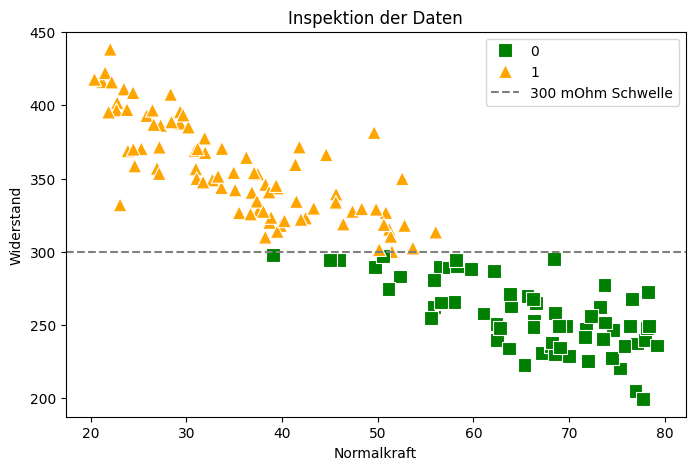

In [6]:
import seaborn as sns

# Streudiagramm
plt.figure(figsize=(8, 5))

# Einteilung in zwei Klassen: defekt (1) und nicht defekt (0) mittels des Keywords 'hue' und 'style'
sns.scatterplot(data=df, x="Normalkraft", y="Widerstand",
                hue="defekt", palette={0: "green", 1: "orange"},
                style="defekt", markers={0: "s", 1: "^"}, s=100)

# Plotten der Grenzlinie
plt.axhline(300, color="gray", linestyle="--", label="300 mOhm Schwelle")
plt.title("Inspektion der Daten")
plt.legend()
plt.show()

### Train-Test Splits und Standardisierung

Diesen Teil kennen wir bereits gut aus den vorherigen Notebooks. Auch hier lohnt es sich, einen Train-Test Split der Daten vorzunehmen und sie für bessere Ergebnisse zu standardisieren.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Feature und Ziel definieren
X = df[["Normalkraft"]].values
y = df["defekt"].values

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Skalierung
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Klassifikation

### Initialisierung und Training
Die eigentliche Klassifikation ist mit `sk-learn` wieder einmal in zwei Zeilen getan. Unter der Haube passiert aber all das, was wir bereits im Theorieteil besprochen haben.

In [10]:
from sklearn.linear_model import LogisticRegression

# Modell initialisieren und trainieren
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

LogisticRegression()

### Visualisierung der Vorhersage
Nach dem Training können wir Vorhersagewahrscheinlichkeiten, die das Modell ausgibt mittels `model.predict_proba` berechnen und plotten:

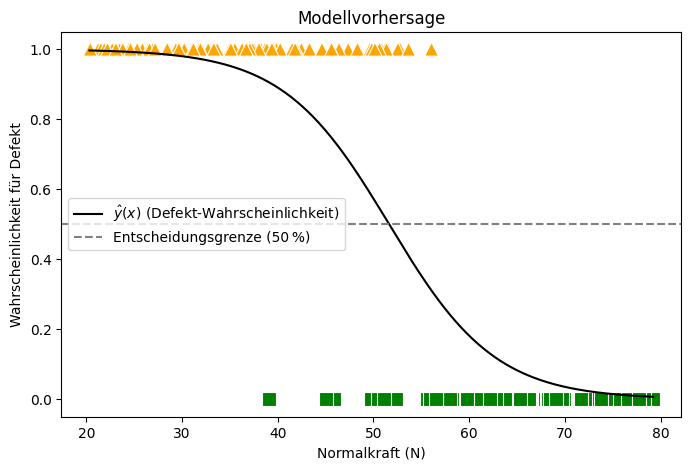

In [11]:
# Wertebereich erzeugen
x_range = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)

# Skalierung des Wertebereichs
x_range_scaled = scaler.transform(x_range)

# Vorhersagewahrscheinlichkeit für Klasse 1
probas = model.predict_proba(x_range_scaled)[:, 1]

# Plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X.flatten(), y=y, hue=y, palette={0: "green", 1: "orange"},
                style=y, markers={0: "s", 1: "^"}, s=100, legend=False)
plt.plot(x_range, probas, color="black", label=r"$\hat{y}(x)$ (Defekt-Wahrscheinlichkeit)")
plt.axhline(0.5, linestyle="--", color="gray", label="Entscheidungsgrenze (50 %)")
plt.xlabel("Normalkraft (N)")
plt.ylabel("Wahrscheinlichkeit für Defekt")
plt.title("Modellvorhersage")
plt.legend()
plt.show()


## Evaluation des Modells

Auf den ersten Blick scheint unser Modell die Daten gut zu beschreiben. Wir können uns nun einige Metriken anschauen, um unseren Eindruck handfest zu überprüfen. Zunächst einmal schauen wir uns den Log-Loss, also den BCE, und die sogenannte Accuracy an.

### 1. BCE und Accuracy

In [12]:
# Finalen BCE-Loss berechnen
from sklearn.metrics import log_loss

y_proba = model.predict_proba(X_test_scaled)[:, 1] # Vorhersagewahrscheinlichkeit für Klasse 1 der Testdaten
final_bce_loss = log_loss(y_test, y_proba)         # Berechnung des finalen BCE-Loss auf den Testdaten

print(f"Finaler BCE-Loss: {final_bce_loss:.4f}")

Finaler BCE-Loss: 0.1580


Der BCE-Loss ist 

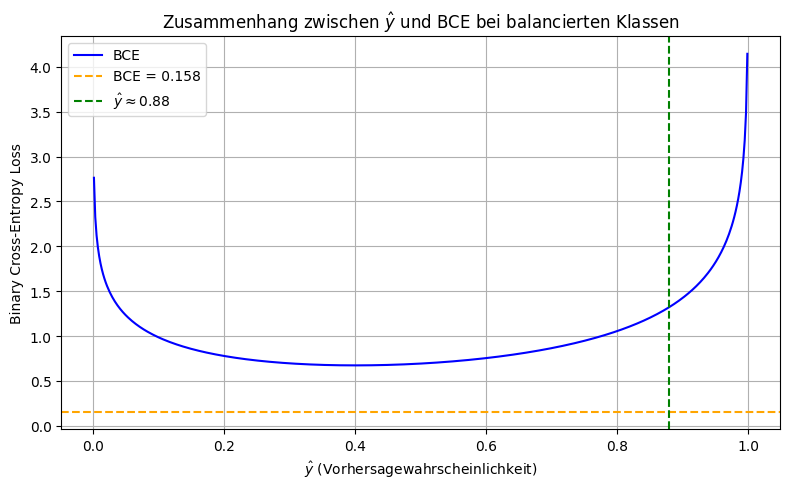

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Range of y_hat values
y_hat = np.linspace(0.001, 0.999, 500)

# Calculate BCE assuming balanced classes and correct predictions
bce = -0.4 * np.log(y_hat) - 0.6 * np.log(1 - y_hat)

# Plot
fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.plot(y_hat, bce, label='BCE', color='blue')
ax1.axhline(0.158, color='orange', linestyle='--', label='BCE = 0.158')
ax1.axvline(0.88, color='green', linestyle='--', label=r'$\hat{y} \approx 0.88$')
ax1.set_xlabel(r'$\hat{y}$ (Vorhersagewahrscheinlichkeit)')
ax1.set_ylabel('Binary Cross-Entropy Loss')
ax1.set_title(r'Zusammenhang zwischen $\hat{y}$ und BCE bei balancierten Klassen')
ax1.grid(True)
ax1.legend()

plt.tight_layout()
plt.show()


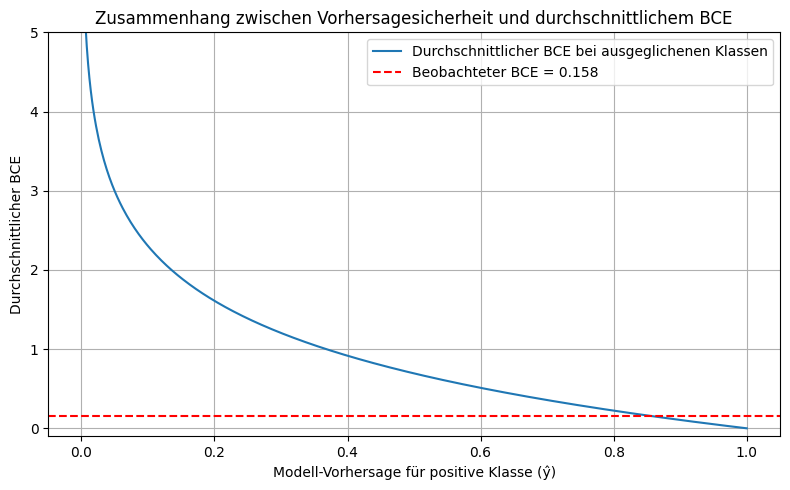

np.float64(0.8537074148296593)

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Definiere BCE als Funktion von y_hat, wobei y=1 (analog auch für y=0)
def bce(y_true, y_hat):
    eps = 1e-15  # numerische Stabilität
    y_hat = np.clip(y_hat, eps, 1 - eps)
    return - (y_true * np.log(y_hat) + (1 - y_true) * np.log(1 - y_hat))

# Durchschnittlicher BCE-Wert für verschiedene Vorhersagesicherheiten
y_hats = np.linspace(0, 1.0, 500)
bce_values_y1 = bce(1, y_hats)
bce_values_y0 = bce(0, 1 - y_hats)  # symmetrisch für y=0 bei 1 - y_hat

# Mittelwert aus BCE(y=1) und BCE(y=0) bei ausgeglichenen Klassen
bce_avg = 0.5 * (bce_values_y1 + bce_values_y0)

# Visualisierung
plt.figure(figsize=(8, 5))
plt.plot(y_hats, bce_avg, label='Durchschnittlicher BCE bei ausgeglichenen Klassen')
plt.axhline(0.158, color='r', linestyle='--', label='Beobachteter BCE = 0.158')
plt.xlabel("Modell-Vorhersage für positive Klasse (ŷ)")
plt.ylabel("Durchschnittlicher BCE")
plt.title("Zusammenhang zwischen Vorhersagesicherheit und durchschnittlichem BCE")
plt.legend()
plt.ylim(-0.1, 5)  # Setze y-Achsen-Limit für bessere Sichtbarkeit
plt.grid(True)
plt.tight_layout()
plt.show()

# Schätze den Bereich der Vorhersagesicherheit, die zu BCE ≈ 0.158 führt
y_hat_closest = y_hats[np.argmin(np.abs(bce_avg - 0.158))]
y_hat_closest


### 2. Precision

### 3. Recall

### 4. F1

### 5. Weitere Metriken

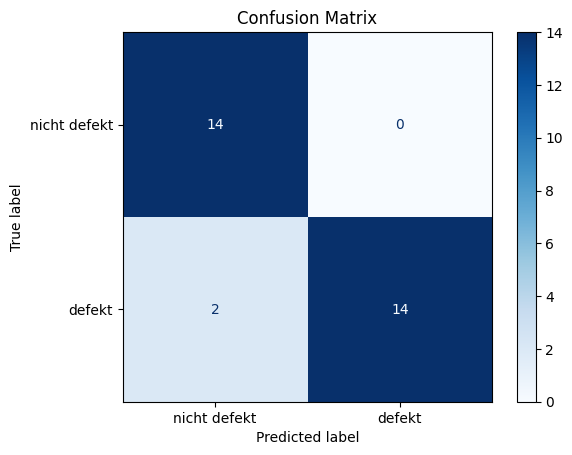

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Klassenvorhersage auf den Testdaten
y_pred = model.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["nicht defekt", "defekt"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


In [13]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2f}")


Accuracy: 0.93


In [14]:
from sklearn.metrics import precision_score, recall_score

prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
print(f"Precision: {prec:.2f}, Recall: {rec:.2f}")


Precision: 1.00, Recall: 0.88


In [15]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred)
print(f"F1-Score: {f1:.2f}")


F1-Score: 0.93


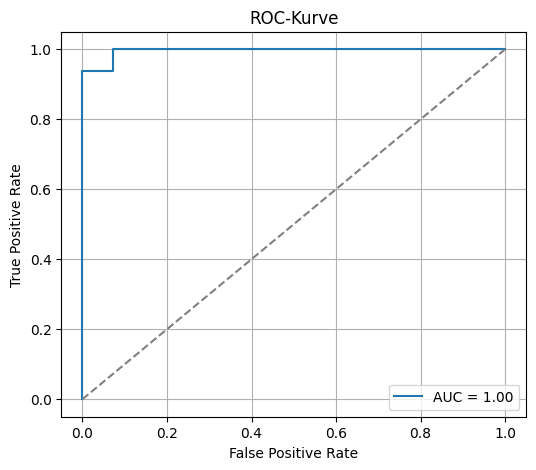

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Wahrscheinlichkeitsvorhersage für Klasse 1
y_proba = model.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-Kurve")
plt.legend()
plt.grid(True)
plt.show()


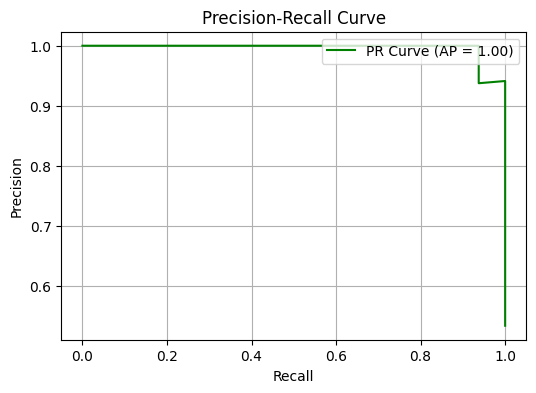

In [17]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Wahrscheinlichkeiten für Klasse 1
y_proba = model.predict_proba(X_test)[:, 1]

# PR-Werte berechnen
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
ap_score = average_precision_score(y_test, y_proba)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f"PR Curve (AP = {ap_score:.2f})", color="green")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()
